# Playing with Normalizing Flows

## Imports

In [120]:
import torch
from flows import RadialFlow, PlanarFlow
from tqdm import tqdm
import torch.nn.functional as F
from models import FCNEncoder, FCNDecoder, FlowModel
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from matplotlib import pyplot as plt
from scipy.special import logsumexp
import numpy as np
from sklearn.datasets import make_moons
from matplotlib import collections  as mc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing transforms

## Unit tests

In [45]:
layer = PlanarFlow(5)

In [8]:
z = torch.FloatTensor([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
f, log_det = layer(z)
print(f)
print(log_det)

tensor([[0.9224, 1.6608, 2.0363, 3.8097, 6.1633],
        [6.1066, 7.4661, 9.3244, 9.2614, 8.4013]], grad_fn=<AddBackward0>)
tensor([9.3409e-01, 1.2707e-04], grad_fn=<LogBackward>)


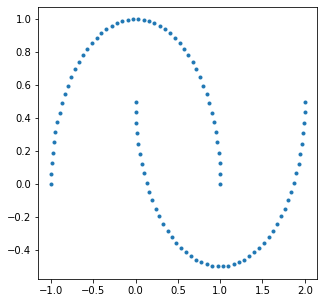

In [100]:
data, _ = make_moons(n_samples=100)
fig = plt.figure(figsize=(5, 5))
plt.plot(data[:, 0], data[:, 1], '.');
plt.savefig('moons.png')

In [80]:
np.linspace(0, 5, 11)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

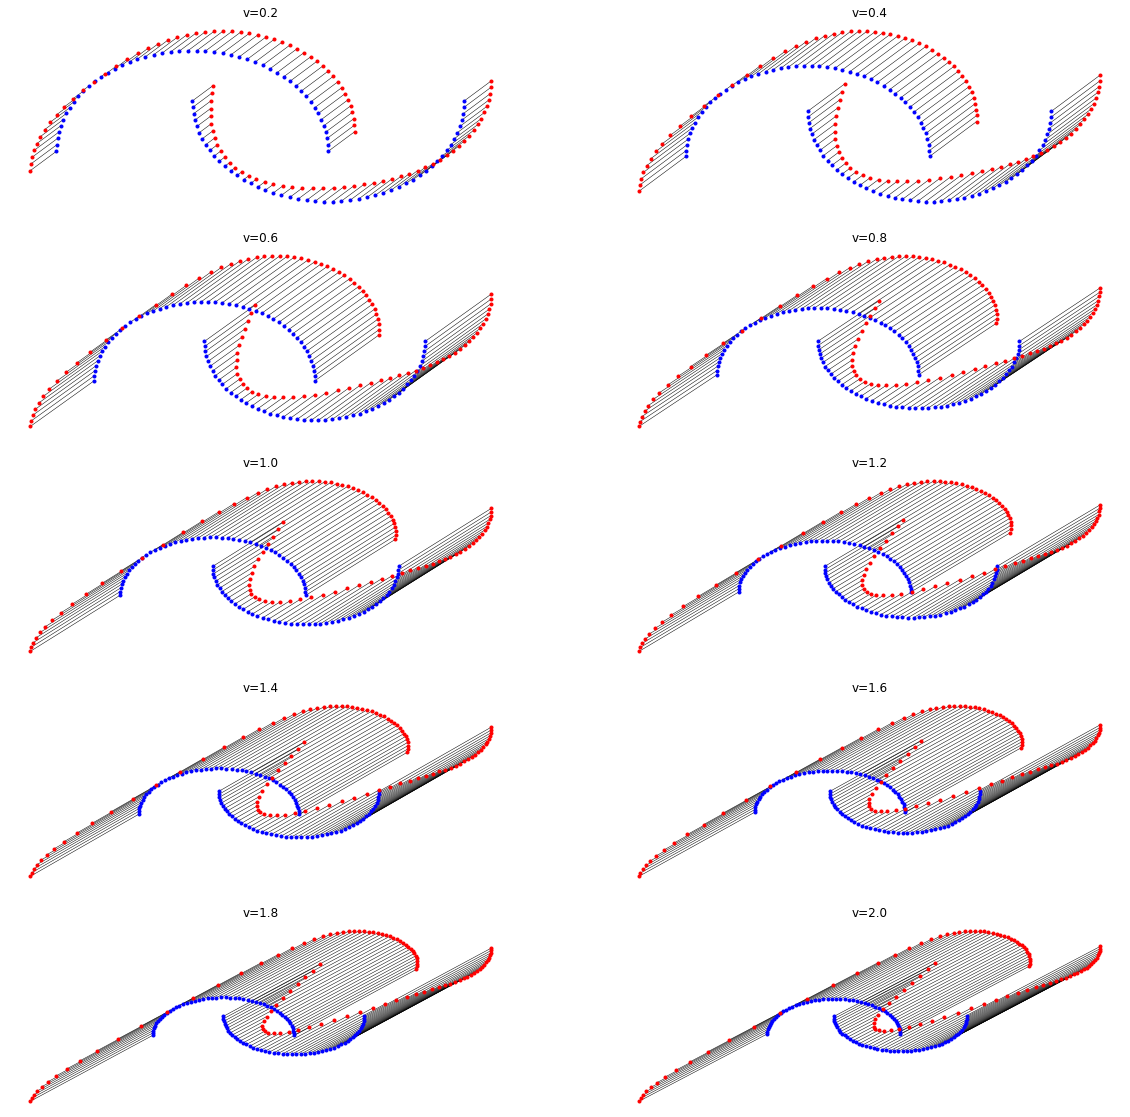

In [82]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

#q0 = np.random.randn(100, 1)
q0, _ = make_moons(n_samples=100)


# for i in range(0)
w = np.ones((2,)) * 2.
b = np.zeros((1,))

for i, v in enumerate(np.linspace(0.2, 2., 10)):
    u = np.ones((2,)) * v
    lin = (q0 @ w + b)[:, np.newaxis]
    q1 = q0 + u * np.tanh(lin)

    axes[i//2, i%2].plot(q0[:, 0], q0[:, 1], '.', color='blue');
    axes[i//2, i%2].axis('off');
    axes[i//2, i%2].plot(q1[:, 0], q1[:, 1], '.', color='red');
    axes[i//2, i%2].set_title('v=%.1f' % v)

    lines = [[q0[i], q1[i]] for i in range(100)]
    lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    axes[i//2, i%2].add_collection(lc)

plt.savefig('pflow-example.png')

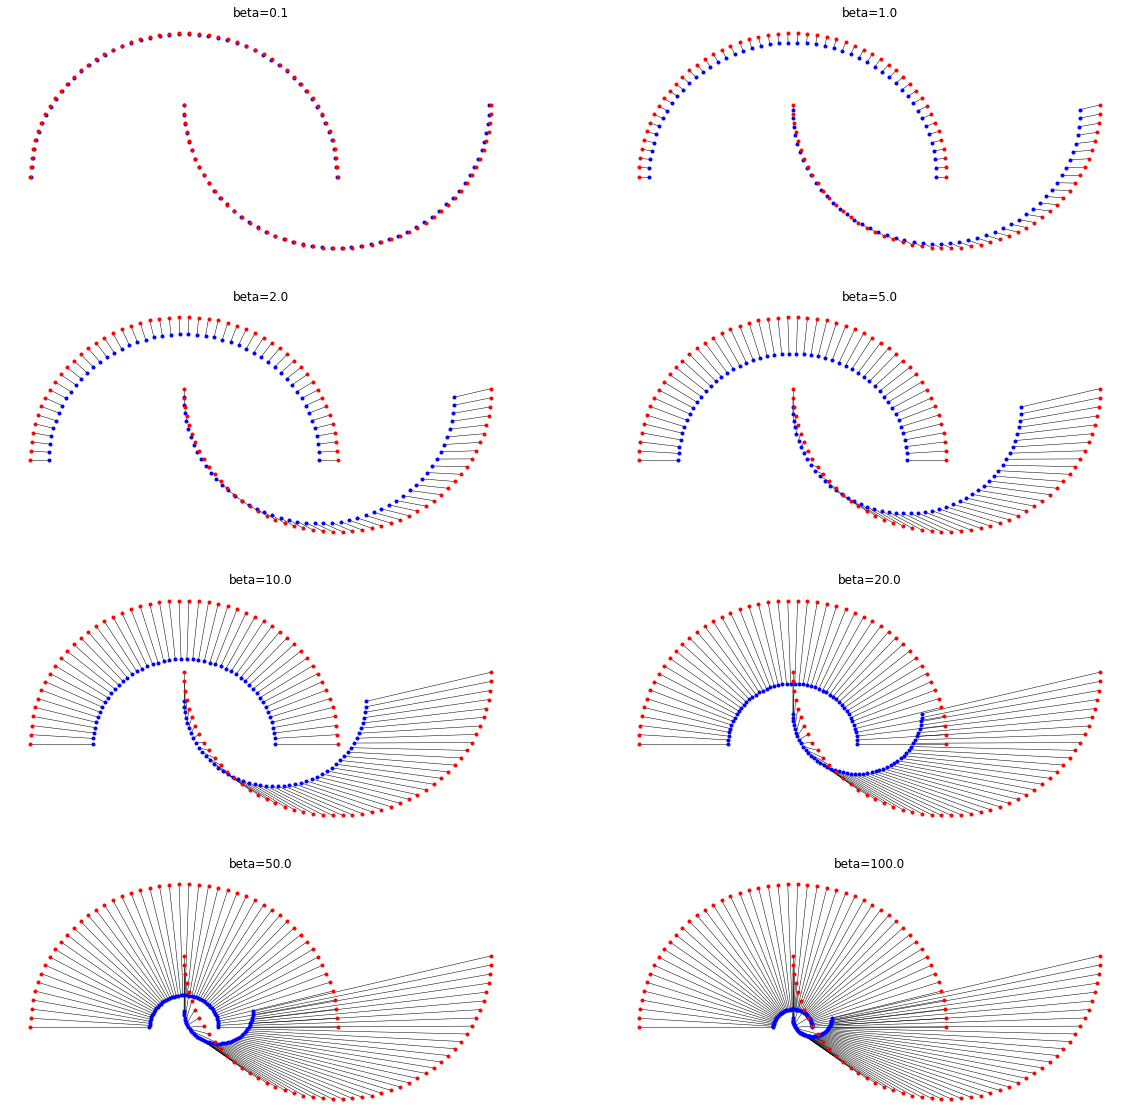

In [114]:
q0, _ = make_moons(n_samples=100)

z0 = np.zeros((2,))
alpha = 3.
h = 1 / (alpha + r)
sub = q0 - z0
r = np.linalg.norm(sub)

fig, axes = plt.subplots(4, 2, figsize=(20, 20))

for i, beta in enumerate([0.1, 1, 2, 5, 10, 20, 50, 100]):
    q1 = q0 + beta * h * sub

    axes[i//2, i%2].plot(q0[:, 0], q0[:, 1], '.', color='blue');
    axes[i//2, i%2].axis('off');
    axes[i//2, i%2].plot(q1[:, 0], q1[:, 1], '.', color='red');
    axes[i//2, i%2].set_title('beta=%.1f' % beta)

    lines = [[q0[i], q1[i]] for i in range(100)]
    lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    axes[i//2, i%2].add_collection(lc)
    
plt.savefig('rflow.png')

## Data

In [83]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [84]:
ds = tfds.load('binarized_mnist', split='train', shuffle_files=True)

In [85]:
len(ds)

50000

In [86]:
np_images = np.load('datasets/bin_mnist.npy')
# np_images = []

# for example in tqdm(ds, total=len(ds)):
#     image = example["image"]
#     np_images.append(image.numpy().reshape(1, 28, 28))
    
# np_images = np.concatenate(np_images, axis=0)

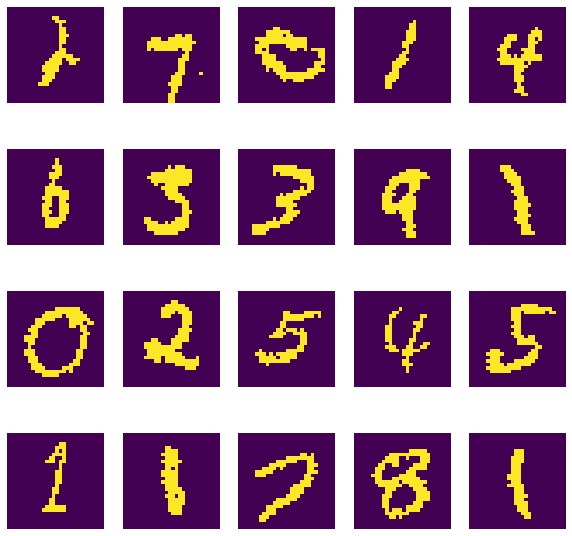

In [94]:
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

for i in range(20):
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].imshow(np_images[i])
    
plt.savefig('bin-mnist.png')

In [ ]:
np.save('bin_mnist.npy', np_images)

In [125]:
from datasets import BinarizedMNIST

In [126]:
#mnist_data = MNIST(root='./', download=True, transform=transforms.ToTensor())
mnist_data = BinarizedMNIST('datasets/bin_mnist.npy')
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

## Model

In [127]:
D = 40

encoder = FCNEncoder(hidden_sizes=[128, 64, 2*D], dim_input=28*28)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=40)
decoder = FCNDecoder(hidden_sizes=[64, 128, 784], dim_input=40)

In [128]:
optimizer = optim.Adam(list(encoder.parameters()) + list(flow_model.parameters()) + list(decoder.parameters()))

In [136]:
loss_fn = BCEWithLogitsLoss()

for i, X_batch in enumerate(data_loader):
    optimizer.zero_grad()
    out = encoder(X_batch.view(-1, 784).float())
    mu, log_sigma = out[:, :40], out[:, 40:]
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    x_hat = decoder(z_k)
    
    
    loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 784).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
    if i % 100 == 0:
        print(f'Iteration {i}, loss: {loss.item()}')
    
    loss.backward()
    optimizer.step()

Iteration 0, loss: 104.99444580078125
Iteration 100, loss: 77.03873443603516
Iteration 200, loss: 55.59918212890625
Iteration 300, loss: 47.94267654418945
Iteration 400, loss: 29.297821044921875
Iteration 500, loss: 22.705965042114258
Iteration 600, loss: 27.41031265258789
Iteration 700, loss: 15.638476371765137
Iteration 800, loss: 5.892423152923584
Iteration 900, loss: 16.155309677124023
Iteration 1000, loss: 4.349727630615234
Iteration 1100, loss: 7.283726692199707
Iteration 1200, loss: 10.881210327148438
Iteration 1300, loss: 19.452749252319336
Iteration 1400, loss: 3.7681972980499268
Iteration 1500, loss: 4.027566909790039
